<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_12_RF_model_tuning2_resampling_with_optimal_params.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

# Import custom functions from data_utils, tuning_utils, and resampling_utils
from data_utils import (
    preprocess_data, split_data, plot_class_distribution,
    # create_preprocessing_pipeline
)

from tuning_utils import (
    evaluate_model_with_probabilities, evaluate_and_store_results_with_probabilities,
    plot_hyperparameter_results, plot_confusion_matrix, plot_roc_curve,
    plot_precision_recall_curve, tune_hyperparameter
)

from resampling_utils import (
    evaluate_model, aggregate_reports, extract_key_metrics,
    plot_key_metrics, evaluate_thresholds
)


#### def create_preprocessing_pipeline

In [3]:
def create_preprocessing_pipeline(numeric_features, categorical_features):
    """
    Create a preprocessing pipeline for numeric and categorical features.

    Parameters:
    - numeric_features: list of str, names of numeric features
    - categorical_features: list of str, names of categorical features

    Returns:
    - sklearn.compose.ColumnTransformer, the preprocessing transformer
    """
    # Define the transformers for numerical and categorical data
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine the transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    print("Preprocessing pipeline created successfully.")
    return preprocessor


### Load & Preprocess




















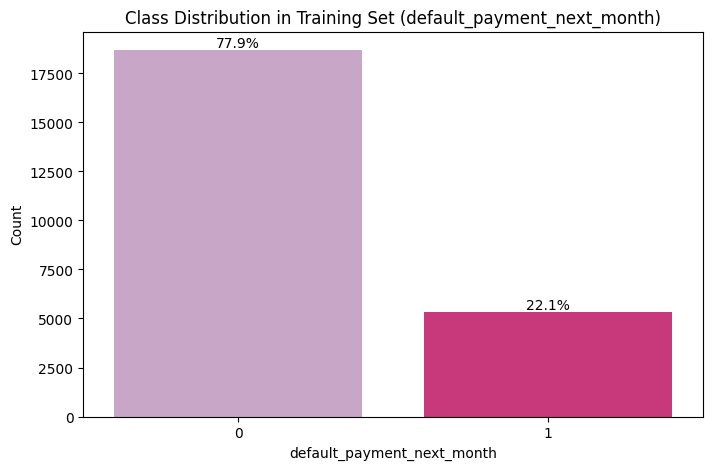

Preprocessing pipeline created successfully.


In [4]:
# Define parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'
optimal_threshold = 0.25

# Load and preprocess data
data = preprocess_data(url, categorical_columns)
X_train, X_test, y_train, y_test = split_data(data, target)
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()
plot_class_distribution(y_train, target)

# Create preprocessing pipeline
preprocessor = create_preprocessing_pipeline(numeric_features, categorical_features)


### Optimal Params

In [10]:
import json

with open('best_params.json', 'r') as file:
    best_params_dict = json.load(file)

for key, value in best_params_dict.items():
    print(f"{key}: {value}")

n_estimators: 300
max_depth: 10
min_samples_split: 20
min_samples_leaf: 1


### Define & Evaluate Baseline Model

In [6]:
# Define baseline model
baseline_model = RandomForestClassifier(random_state=42)
baseline_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', RandomUnderSampler(random_state=42)),
    ('model', baseline_model)
])

# Initialize results list and best parameters dictionary
results_list = []
best_params = {}

# Train and evaluate the baseline model
baseline_pipeline.fit(X_train, y_train)
results_list = evaluate_and_store_results_with_probabilities(baseline_pipeline, X_test, y_test, 'Baseline Model', results_list, optimal_threshold)

# Print baseline results
print("Baseline Model Results: ", results_list[-1])


Classification Report for Baseline Model:
               precision    recall  f1-score   support

           0       0.93      0.25      0.39      4673
           1       0.26      0.93      0.41      1327

    accuracy                           0.40      6000
   macro avg       0.59      0.59      0.40      6000
weighted avg       0.78      0.40      0.40      6000

Baseline Model Results:  {'0': {'precision': 0.9273162939297125, 'recall': 0.2484485341322491, 'f1-score': 0.39189873417721516, 'support': 4673}, '1': {'precision': 0.2603201347935973, 'recall': 0.9314242652599849, 'f1-score': 0.40691358024691354, 'support': 1327}, 'accuracy': 0.3995, 'macro avg': {'precision': 0.5938182143616548, 'recall': 0.589936399696117, 'f1-score': 0.39940615721206435, 'support': 6000}, 'weighted avg': {'precision': 0.7797989767341084, 'recall': 0.3995, 'f1-score': 0.3952195176329634, 'support': 6000}, 'model': 'Baseline Model'}


### Define and Evaluate Resampling Methods

In [11]:
# Function to evaluate different resampling methods
def evaluate_resampling_method(preprocessor, resampler, resampler_name, X_train, y_train, X_test, y_test, best_params, results_list, optimal_threshold):
    final_model = RandomForestClassifier(**best_params_dict)
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('resampler', resampler),
        ('model', final_model)
    ])

    pipeline.fit(X_train, y_train)
    results_list = evaluate_and_store_results_with_probabilities(pipeline, X_test, y_test, f'{resampler_name} Model', results_list, optimal_threshold)
    print(f"Results with {resampler_name}: ", results_list[-1])
    return results_list

# Define resampling techniques
resampling_methods = {
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}

# Evaluate each resampling method
for resampler_name, resampler in resampling_methods.items():
    results_list = evaluate_resampling_method(preprocessor, resampler, resampler_name, X_train, y_train, X_test, y_test, best_params, results_list, optimal_threshold)


Classification Report for RandomUnderSampler Model:
               precision    recall  f1-score   support

           0       0.95      0.20      0.33      4673
           1       0.25      0.97      0.40      1327

    accuracy                           0.37      6000
   macro avg       0.60      0.58      0.37      6000
weighted avg       0.80      0.37      0.34      6000

Results with RandomUnderSampler:  {'0': {'precision': 0.953464322647363, 'recall': 0.19730365931949498, 'f1-score': 0.3269503546099291, 'support': 4673}, '1': {'precision': 0.2547188555533479, 'recall': 0.9660889223813113, 'f1-score': 0.4031446540880503, 'support': 1327}, 'accuracy': 0.36733333333333335, 'macro avg': {'precision': 0.6040915891003554, 'recall': 0.5816962908504031, 'f1-score': 0.3650475043489897, 'support': 6000}, 'weighted avg': {'precision': 0.7989251168417367, 'recall': 0.36733333333333335, 'f1-score': 0.34380199384450694, 'support': 6000}, 'model': 'RandomUnderSampler Model'}
Classification Rep

### Aggreagte Results

In [12]:
# Aggregate results
def aggregate_results(results_list):
    aggregated_data = []
    for result in results_list:
        model_name = result['model']
        for class_label in ['0', '1']:
            precision = result[class_label]['precision']
            recall = result[class_label]['recall']
            f1 = result[class_label]['f1-score']
            support = result[class_label]['support']
            aggregated_data.append({
                'model': model_name,
                'class': class_label,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'support': support
            })
    return pd.DataFrame(aggregated_data)

# Aggregate the results into a DataFrame
results_df = aggregate_results(results_list)
print(results_df)


                      model class  precision    recall        f1  support
0            Baseline Model     0   0.927316  0.248449  0.391899     4673
1            Baseline Model     1   0.260320  0.931424  0.406914     1327
2  RandomUnderSampler Model     0   0.953464  0.197304  0.326950     4673
3  RandomUnderSampler Model     1   0.254719  0.966089  0.403145     1327
4               SMOTE Model     0   0.936404  0.274128  0.424102     4673
5               SMOTE Model     1   0.267703  0.934439  0.416177     1327
6              ADASYN Model     0   0.952486  0.184464  0.309071     4673
7              ADASYN Model     1   0.252012  0.967596  0.399875     1327
8            SMOTEENN Model     0   0.936930  0.263856  0.411755     4673
9            SMOTEENN Model     1   0.265585  0.937453  0.413908     1327


### Plot Results

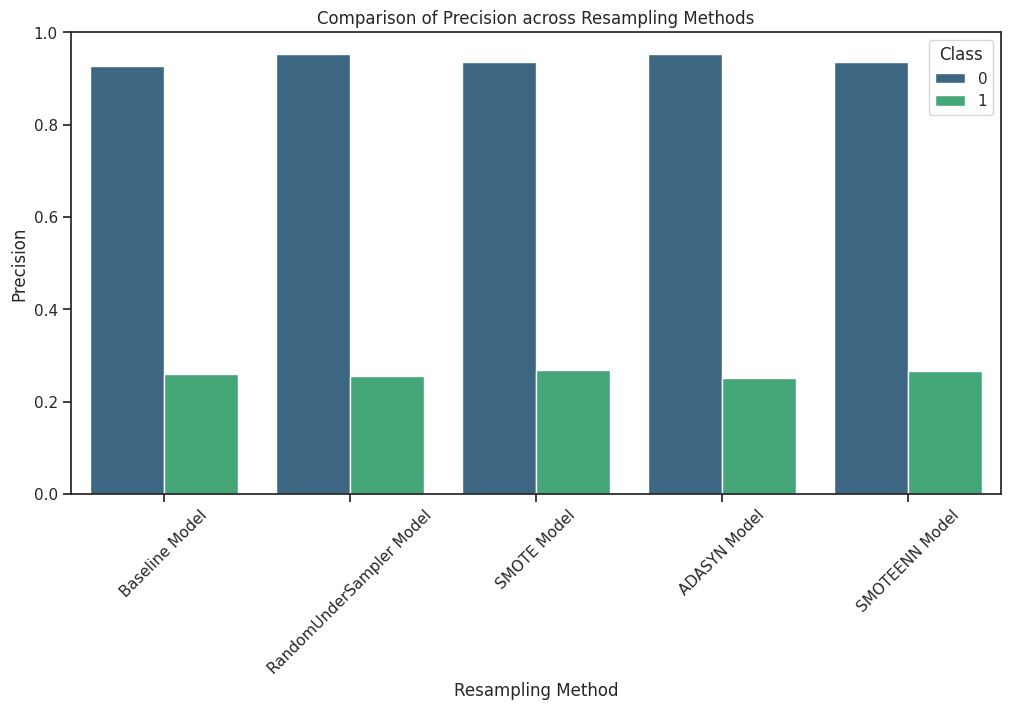

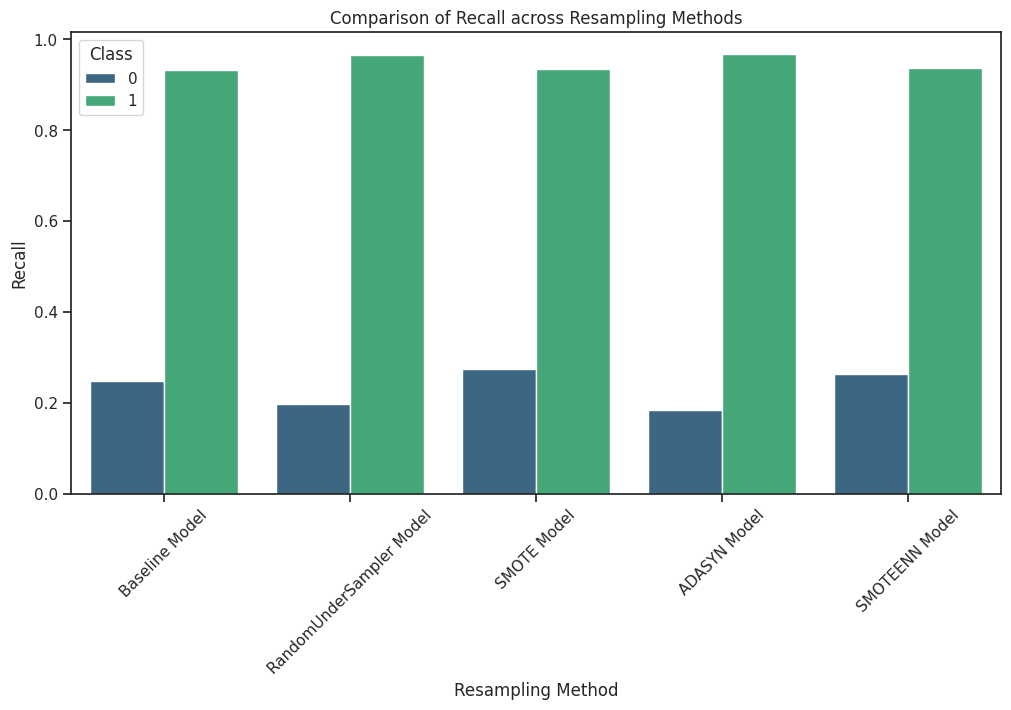

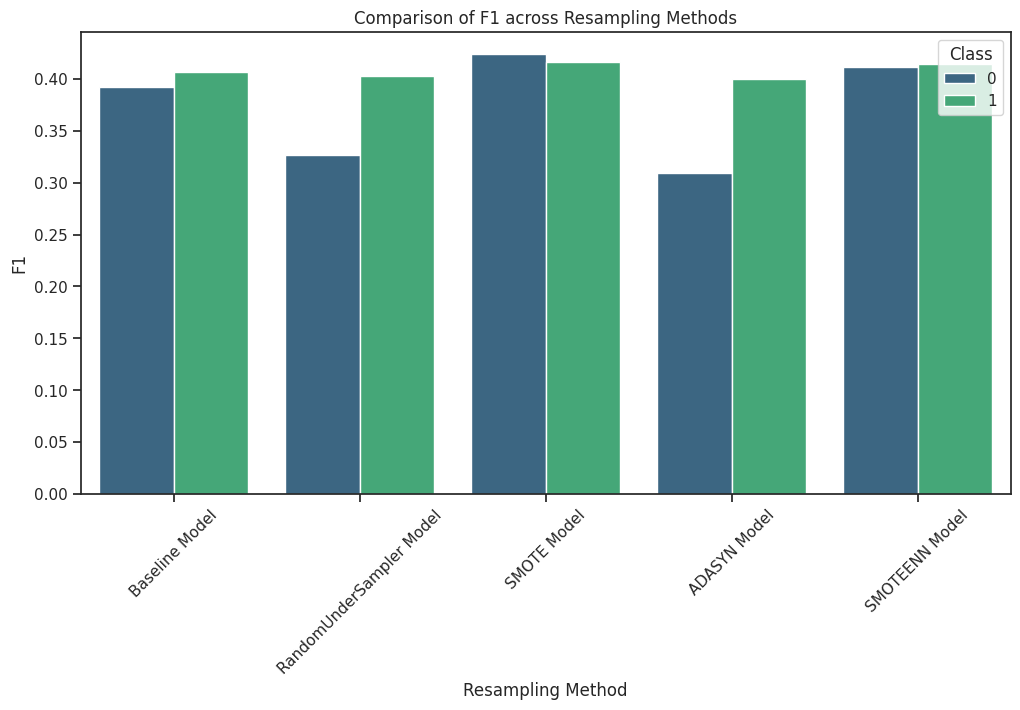

In [13]:
def plot_metrics(results_df, metric):
    sns.set_style('ticks')
    sns.set_context('notebook')
    plt.figure(figsize=(12, 6))
    sns.barplot(x='model', y=metric, hue='class', data=results_df, palette='viridis')
    plt.title(f'Comparison of {metric.capitalize()} across Resampling Methods')
    plt.xlabel('Resampling Method')
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=45)
    plt.legend(title='Class', loc='best')
    plt.show()

# Plot precision, recall, and f1 scores
plot_metrics(results_df, 'precision')
plot_metrics(results_df, 'recall')
plot_metrics(results_df, 'f1')


In [14]:
# Analysis of results
def analyze_results(results_df):
    for metric in ['precision', 'recall', 'f1']:
        print(f"\nAnalysis of {metric.capitalize()} for Class 1 (Loan Defaults):")
        class_1_results = results_df[(results_df['class'] == '1') & (results_df['model'].str.contains('Model'))]
        best_model = class_1_results.loc[class_1_results[metric].idxmax()]
        print(f"Best {metric.capitalize()} Model: {best_model['model']}")
        print(f"{metric.capitalize()}: {best_model[metric]}")
        print(f"Support: {best_model['support']}")

# Analyze the results
analyze_results(results_df)



Analysis of Precision for Class 1 (Loan Defaults):
Best Precision Model: SMOTE Model
Precision: 0.26770293609671847
Support: 1327

Analysis of Recall for Class 1 (Loan Defaults):
Best Recall Model: ADASYN Model
Recall: 0.9675960813865863
Support: 1327

Analysis of F1 for Class 1 (Loan Defaults):
Best F1 Model: SMOTE Model
F1: 0.41617721094143306
Support: 1327


### Tune Baseline Model with Optimal Resampling Method (ADASYN)

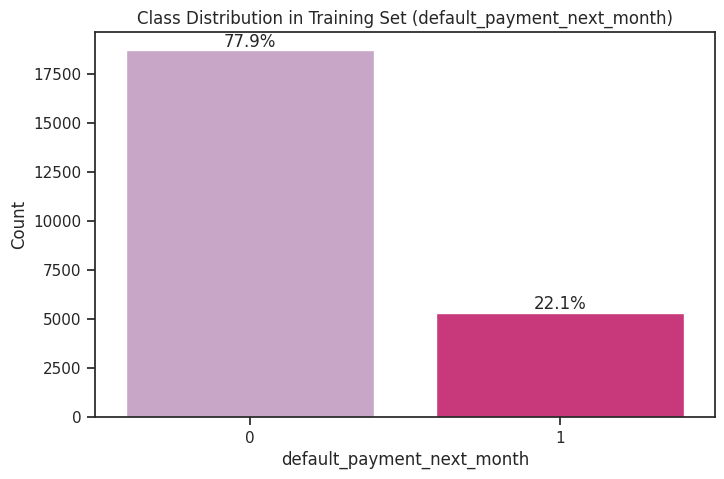

Preprocessing pipeline created successfully.


In [16]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

# Import custom functions from data_utils and tuning_utils
from data_utils import (
    preprocess_data, split_data, plot_class_distribution,
    create_preprocessing_pipeline
)
from tuning_utils import (
    evaluate_and_store_results_with_probabilities, plot_hyperparameter_results
)

# Load the best parameters from JSON
with open('best_params.json', 'r') as file:
    best_params_dict = json.load(file)

# Define the final parameters
final_params = {
    'n_estimators': best_params_dict['n_estimators'],
    'max_depth': best_params_dict['max_depth'],
    'min_samples_split': best_params_dict['min_samples_split'],
    'min_samples_leaf': best_params_dict['min_samples_leaf'],
    'random_state': 42
}

# Parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'
optimal_threshold = 0.25

# Load and preprocess data
data = preprocess_data(url, categorical_columns)
X_train, X_test, y_train, y_test = split_data(data, target)
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()
plot_class_distribution(y_train, target)

# Create preprocessing pipeline
preprocessor = create_preprocessing_pipeline(numeric_features, categorical_features)

# Define the baseline model
baseline_model = RandomForestClassifier(random_state=42)
baseline_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', ADASYN(random_state=42)),
    ('model', baseline_model)
])


### Tune Hyperparameters with Optimal Resampling (ADASYN)

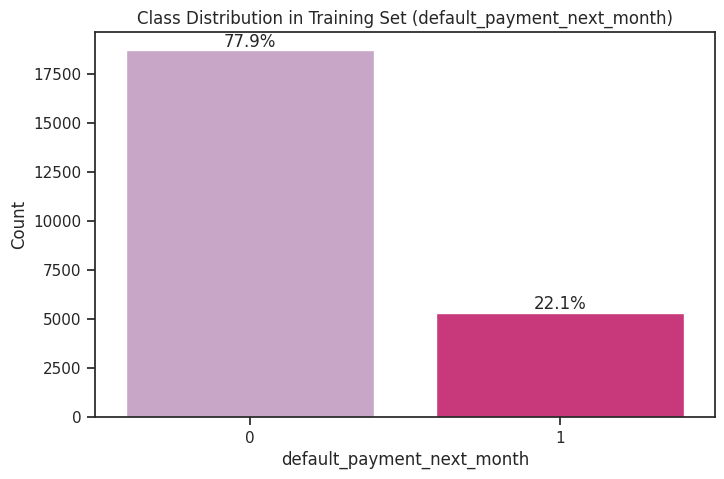

Classification Report for Baseline Model:
               precision    recall  f1-score   support

           0       0.90      0.48      0.62      4673
           1       0.30      0.81      0.44      1327

    accuracy                           0.55      6000
   macro avg       0.60      0.64      0.53      6000
weighted avg       0.77      0.55      0.58      6000

Baseline Model Results:  {'0': {'precision': 0.8963291649858814, 'recall': 0.4754975390541408, 'f1-score': 0.6213646532438479, 'support': 4673}, '1': {'precision': 0.30389094007384265, 'recall': 0.8063300678221552, 'f1-score': 0.4414191419141914, 'support': 1327}, 'accuracy': 0.5486666666666666, 'macro avg': {'precision': 0.600110052529862, 'recall': 0.6409138034381481, 'f1-score': 0.5313918975790197, 'support': 6000}, 'weighted avg': {'precision': 0.7653015775761689, 'recall': 0.5486666666666666, 'f1-score': 0.5815667043214389, 'support': 6000}, 'model': 'Baseline Model'}
Classification Report for Tuned model__n_estimator

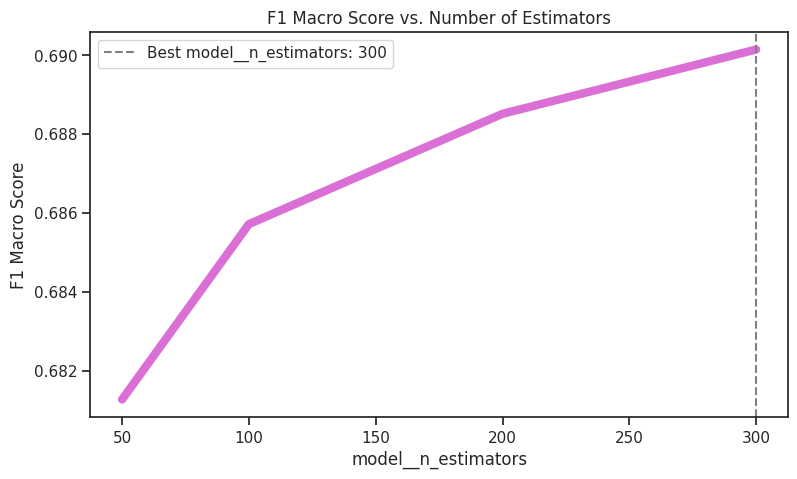

Classification Report for Tuned model__max_depth:
               precision    recall  f1-score   support

           0       0.95      0.19      0.32      4673
           1       0.25      0.97      0.40      1327

    accuracy                           0.36      6000
   macro avg       0.60      0.58      0.36      6000
weighted avg       0.80      0.36      0.34      6000

Best model__max_depth: 10


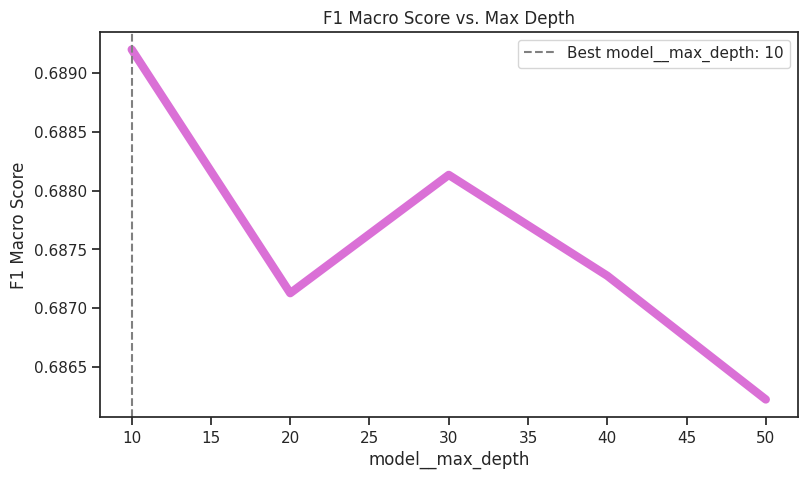

Classification Report for Tuned model__min_samples_split:
               precision    recall  f1-score   support

           0       0.90      0.44      0.59      4673
           1       0.30      0.83      0.44      1327

    accuracy                           0.53      6000
   macro avg       0.60      0.64      0.52      6000
weighted avg       0.77      0.53      0.56      6000

Best model__min_samples_split: 10


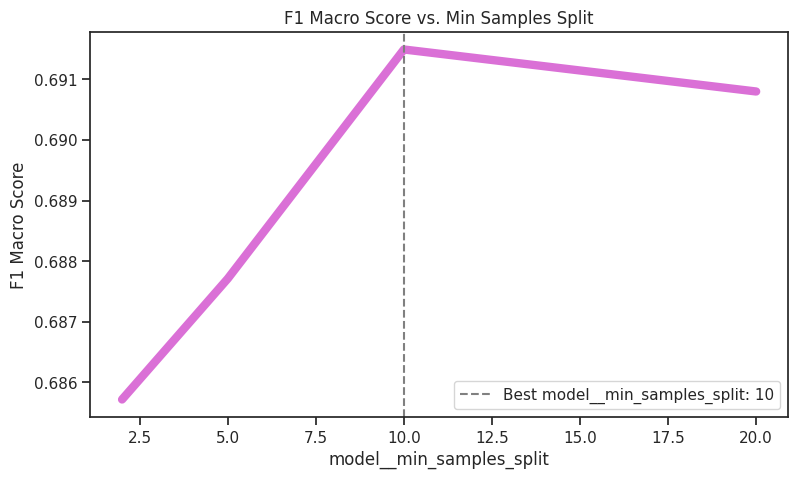

Classification Report for Tuned model__min_samples_leaf:
               precision    recall  f1-score   support

           0       0.92      0.38      0.54      4673
           1       0.29      0.89      0.44      1327

    accuracy                           0.49      6000
   macro avg       0.61      0.63      0.49      6000
weighted avg       0.78      0.49      0.52      6000

Best model__min_samples_leaf: 8


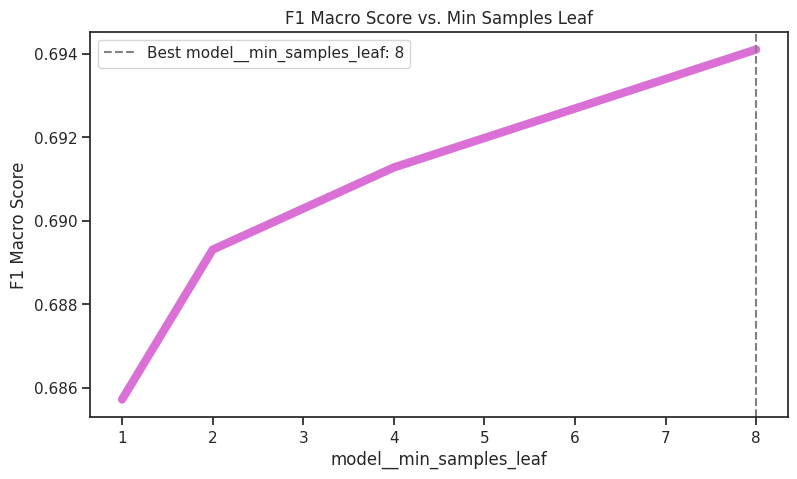

Best parameters saved to best_params.json
Classification Report for Final Model:
               precision    recall  f1-score   support

           0       0.95      0.18      0.30      4673
           1       0.25      0.97      0.40      1327

    accuracy                           0.35      6000
   macro avg       0.60      0.57      0.35      6000
weighted avg       0.80      0.35      0.32      6000

Final Model Results:  {'0': {'precision': 0.95152198421646, 'recall': 0.18061202653541622, 'f1-score': 0.30359712230215824, 'support': 4673}, '1': {'precision': 0.25112458439272445, 'recall': 0.9675960813865863, 'f1-score': 0.39875776397515533, 'support': 1327}, 'accuracy': 0.3546666666666667, 'macro avg': {'precision': 0.6013232843045921, 'recall': 0.5741040539610013, 'f1-score': 0.3511774431386568, 'support': 6000}, 'weighted avg': {'precision': 0.7966174259554438, 'recall': 0.3546666666666667, 'f1-score': 0.3246434842188361, 'support': 6000}, 'model': 'Final Model'}


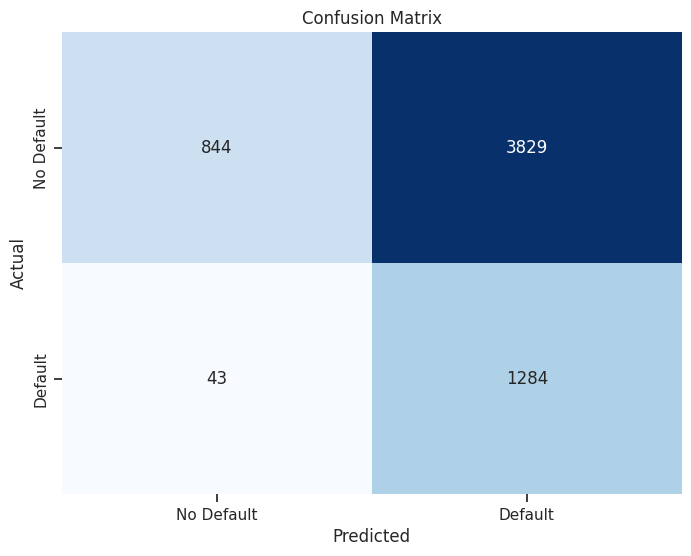

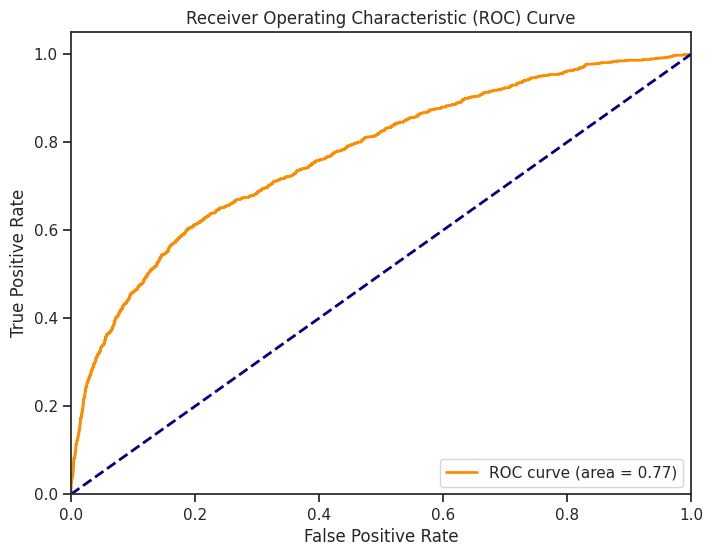

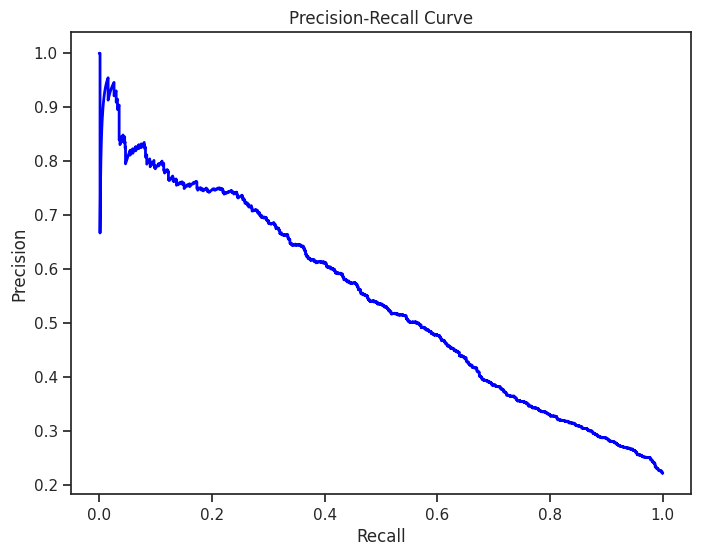

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

from data_utils import (
    preprocess_data, split_data, plot_class_distribution
)
from tuning_utils import (
    evaluate_and_store_results_with_probabilities, plot_hyperparameter_results,
    plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
)

# Load the best parameters from JSON if they exist, otherwise initialize them
try:
    with open('best_params.json', 'r') as file:
        best_params_dict = json.load(file)
except FileNotFoundError:
    best_params_dict = {
        'n_estimators': 100,
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'optimal_threshold': 0.25
    }

# Parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'
optimal_threshold = best_params_dict.get('optimal_threshold', 0.25)

# Load and preprocess data
data = preprocess_data(url, categorical_columns)
X_train, X_test, y_train, y_test = split_data(data, target)
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()
plot_class_distribution(y_train, target)

# Create preprocessing components directly
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Initialize results list
results_list = []

# Baseline model
baseline_model = RandomForestClassifier(random_state=42)
complete_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', ADASYN(random_state=42)),
    ('model', baseline_model)
])

# Train and evaluate the baseline model
complete_pipeline.fit(X_train, y_train)
results_list = evaluate_and_store_results_with_probabilities(complete_pipeline, X_test, y_test, 'Baseline Model', results_list, optimal_threshold)

# Print baseline results
print("Baseline Model Results: ", results_list[-1])

# Function to tune a single hyperparameter
def tune_hyperparameter(param_grid, param_name, title, complete_pipeline, X_train, y_train, X_test, y_test, results_list, best_params, optimal_threshold):
    grid_search = GridSearchCV(estimator=complete_pipeline, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    results_list = evaluate_and_store_results_with_probabilities(best_model, X_test, y_test, f'Tuned {param_name}', results_list, optimal_threshold)
    plot_hyperparameter_results(grid_search, param_name, title)
    best_params.update(grid_search.best_params_)
    return results_list, best_params

# Hyperparameter tuning for n_estimators
param_grid_n_estimators = {'model__n_estimators': [50, 100, 200, 300]}
results_list, best_params_dict = tune_hyperparameter(param_grid_n_estimators, 'model__n_estimators', 'F1 Macro Score vs. Number of Estimators', complete_pipeline, X_train, y_train, X_test, y_test, results_list, best_params_dict, optimal_threshold)

# Hyperparameter tuning for max_depth
param_grid_max_depth = {'model__max_depth': [None, 10, 20, 30, 40, 50]}
results_list, best_params_dict = tune_hyperparameter(param_grid_max_depth, 'model__max_depth', 'F1 Macro Score vs. Max Depth', complete_pipeline, X_train, y_train, X_test, y_test, results_list, best_params_dict, optimal_threshold)

# Hyperparameter tuning for min_samples_split
param_grid_min_samples_split = {'model__min_samples_split': [2, 5, 10, 20]}
results_list, best_params_dict = tune_hyperparameter(param_grid_min_samples_split, 'model__min_samples_split', 'F1 Macro Score vs. Min Samples Split', complete_pipeline, X_train, y_train, X_test, y_test, results_list, best_params_dict, optimal_threshold)

# Hyperparameter tuning for min_samples_leaf
param_grid_min_samples_leaf = {'model__min_samples_leaf': [1, 2, 4, 8]}
results_list, best_params_dict = tune_hyperparameter(param_grid_min_samples_leaf, 'model__min_samples_leaf', 'F1 Macro Score vs. Min Samples Leaf', complete_pipeline, X_train, y_train, X_test, y_test, results_list, best_params_dict, optimal_threshold)

# Save the best parameters to a JSON file
with open('best_params_final.json', 'w') as file:
    json.dump(best_params_dict, file, indent=4)
print("Best parameters saved to best_params_final.json")

# Use the best parameters to create the final model
final_model = RandomForestClassifier(**{
    'n_estimators': best_params_dict['model__n_estimators'],
    'max_depth': best_params_dict['model__max_depth'],
    'min_samples_split': best_params_dict['model__min_samples_split'],
    'min_samples_leaf': best_params_dict['model__min_samples_leaf'],
    'random_state': 42
})
final_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('resampler', ADASYN(random_state=42)),
    ('model', final_model)
])

# Train and evaluate the final model
final_pipeline.fit(X_train, y_train)
results_list = evaluate_and_store_results_with_probabilities(final_pipeline, X_test, y_test, 'Final Model', results_list, optimal_threshold)

# Print the final results
print("Final Model Results: ", results_list[-1])

# Plot additional metrics for the final model
y_pred_prob = final_pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= optimal_threshold).astype(int)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_pred_prob)
plot_precision_recall_curve(y_test, y_pred_prob)


In [25]:
best_params_dict

{'n_estimators': 300,
 'max_depth': 10,
 'min_samples_split': 20,
 'min_samples_leaf': 1,
 'model__n_estimators': 300,
 'model__max_depth': 10,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 8}

### Save Best Params

In [31]:
# import json

# # Save the best parameters to a JSON file
# with open('best_params_final.json', 'w') as file:
#     json.dump(best_params_dict, file, indent=4)
# print("Best parameters saved to best_params_final.json")

# # Load the best parameters from the JSON file
# with open('best_params_final.json', 'r') as file:
#     best_params_final_dict = json.load(file)

# for i in best_params_final_dict:
#     print(f"{i}: {best_params_final_dict[i]}")

In [40]:
import pandas as pd

# Function to extract metrics from results list
def extract_metrics(results_list):
    metrics = ['precision', 'recall', 'f1-score']
    classes = ['0', '1']

    extracted_data = []

    for result in results_list:
        model_name = result['model']
        for cls in classes:
            for metric in metrics:
                value = result[cls][metric]
                extracted_data.append({
                    'model': model_name,
                    'class': cls,
                    'metric': metric,
                    'value': value
                })

    return pd.DataFrame(extracted_data)

# Convert results list to DataFrame
results_df = extract_metrics(results_list)


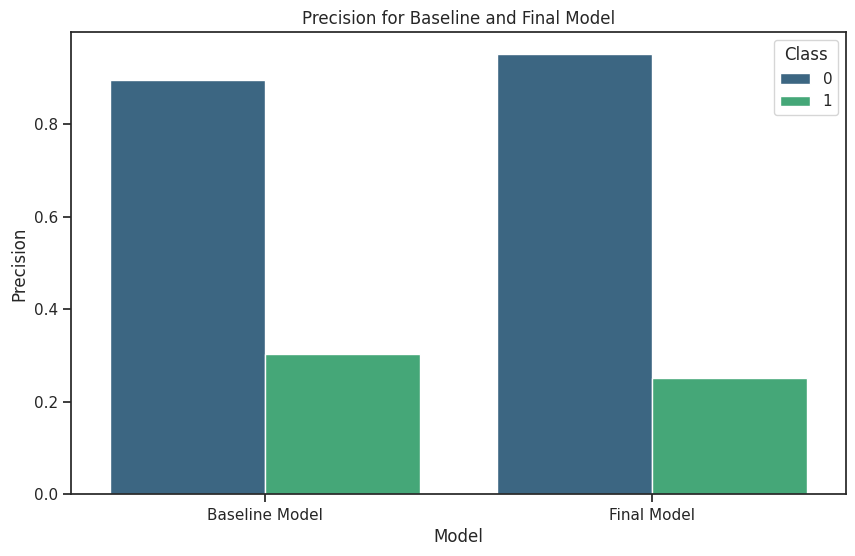

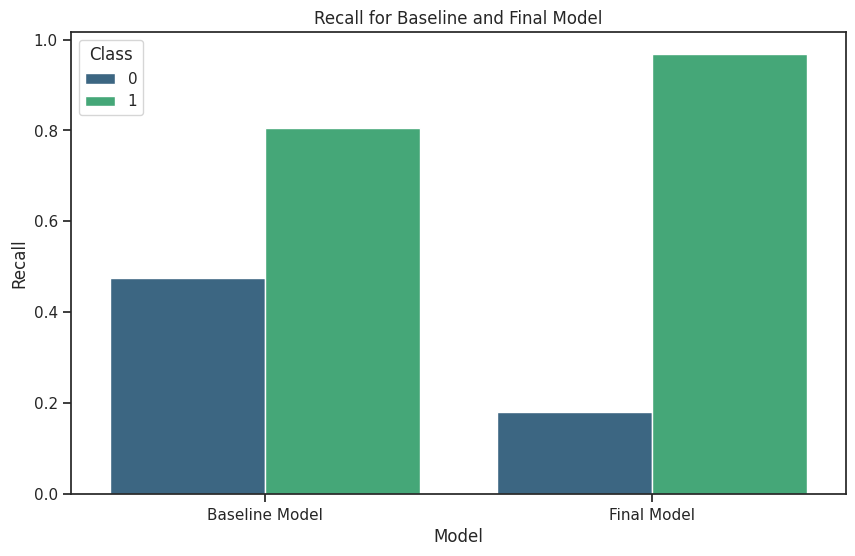

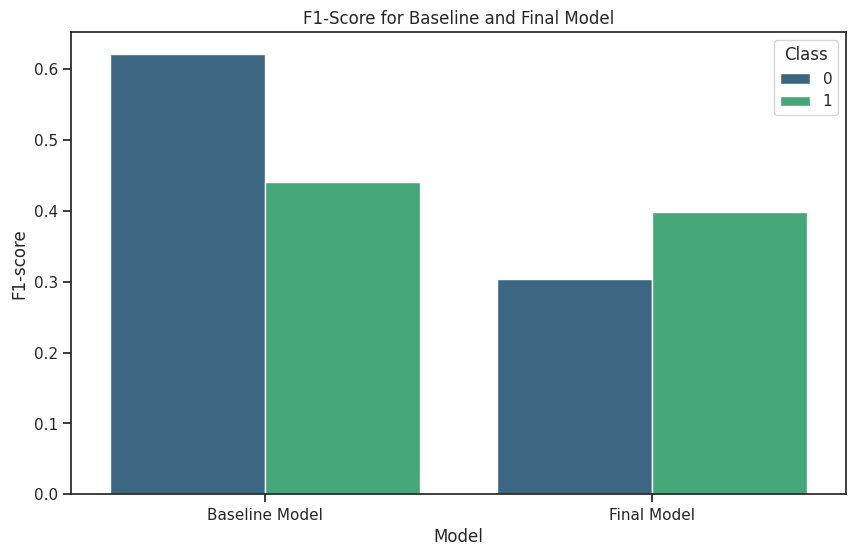

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for specific models
filtered_results_df = results_df[results_df['model'].isin(['Baseline Model', 'Final Model'])]

# Function to plot metrics
def plot_metrics(filtered_results_df, metric, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='model', y='value', hue='class', data=filtered_results_df[filtered_results_df['metric'] == metric], palette='viridis')
    plt.title(title)
    plt.xlabel('Model')
    plt.ylabel(metric.capitalize())
    plt.legend(title='Class')
    plt.show()

# Plot precision for Baseline Model and Final Model
plot_metrics(filtered_results_df, 'precision', 'Precision for Baseline and Final Model')

# Plot recall for Baseline Model and Final Model
plot_metrics(filtered_results_df, 'recall', 'Recall for Baseline and Final Model')

# Plot f1-score for Baseline Model and Final Model
plot_metrics(filtered_results_df, 'f1-score', 'F1-Score for Baseline and Final Model')


In [39]:
# Display the filtered DataFrame
print(filtered_results_df)

             model class     metric     value
0   Baseline Model     0  precision  0.896329
1   Baseline Model     0     recall  0.475498
2   Baseline Model     0   f1-score  0.621365
3   Baseline Model     1  precision  0.303891
4   Baseline Model     1     recall  0.806330
5   Baseline Model     1   f1-score  0.441419
30     Final Model     0  precision  0.951522
31     Final Model     0     recall  0.180612
32     Final Model     0   f1-score  0.303597
33     Final Model     1  precision  0.251125
34     Final Model     1     recall  0.967596
35     Final Model     1   f1-score  0.398758


### Analyzing Final Model Performance

### Baseline Model:
- **Class 0 (No Default)**:
  - **Precision**: 0.896329
  - **Recall**: 0.475498
  - **F1-Score**: 0.621365
- **Class 1 (Default)**:
  - **Precision**: 0.303891
  - **Recall**: 0.806330
  - **F1-Score**: 0.441419

### Final Model:
- **Class 0 (No Default)**:
  - **Precision**: 0.951522
  - **Recall**: 0.180612
  - **F1-Score**: 0.303597
- **Class 1 (Default)**:
  - **Precision**: 0.251125
  - **Recall**: 0.967596
  - **F1-Score**: 0.398758

### Analysis:
1. **Precision**:
   - For Class 0 (No Default), the `Final Model` has a higher precision (0.951522) compared to the `Baseline Model` (0.896329). This means the `Final Model` is more accurate in identifying non-defaults.
   - For Class 1 (Default), the `Baseline Model` has a higher precision (0.303891) than the `Final Model` (0.251125). This indicates that the `Baseline Model` is more accurate in identifying defaults.

2. **Recall**:
   - For Class 0 (No Default), the `Baseline Model` has a much higher recall (0.475498) than the `Final Model` (0.180612). This means the `Baseline Model` is better at identifying all true non-defaults.
   - For Class 1 (Default), the `Final Model` has a significantly higher recall (0.967596) compared to the `Baseline Model` (0.806330). This indicates that the `Final Model` is much better at identifying all true defaults.

3. **F1-Score**:
   - For Class 0 (No Default), the `Baseline Model` has a higher f1-score (0.621365) compared to the `Final Model` (0.303597). This suggests that the `Baseline Model` strikes a better balance between precision and recall for non-defaults.
   - For Class 1 (Default), the `Baseline Model` also has a higher f1-score (0.441419) than the `Final Model` (0.398758), indicating better overall performance in identifying defaults.

### Recommendations:
1. **Recall for Class 1 (Default)**:
   - The `Final Model` shows a significant improvement in recall for defaults, which is crucial for reducing the risk of missing actual defaults. This is beneficial if the primary goal is to minimize false negatives for defaults.

2. **Precision for Class 1 (Default)**:
   - The `Baseline Model` has better precision for defaults. If the primary concern is to minimize false positives for defaults, the `Baseline Model` performs better.

3. **Overall Balance**:
   - The `Baseline Model` generally provides a better balance between precision and recall for both classes. If a balanced approach is preferred, sticking with the `Baseline Model` might be advisable.

4. **Improving the Final Model**:
   - To improve the `Final Model`, focus on enhancing its precision for defaults while maintaining its high recall. This can be done by fine-tuning hyperparameters, further feature engineering, or exploring additional resampling techniques.

5. **Threshold Adjustment**:
   - Consider adjusting the decision threshold to find a balance that improves the f1-score for Class 1 without significantly compromising recall.

By focusing on these aspects, you can enhance the model's performance based on the specific requirements and goals of the project.

#### Write Data Utils Script

In [1]:
script_content = r'''
# data_utils.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Load the dataset from a URL
def load_data_from_url(url):
    """
    Load the dataset from a specified URL.

    Parameters:
    - url: str, URL of the dataset

    Returns:
    - pd.DataFrame, loaded dataset
    """
    try:
        df = pd.read_excel(url, header=1)
    except Exception as e:
        print(f"Error loading data from URL: {e}")
        return None
    return df

# Clean column names
def clean_column_names(df):
    """
    Clean the column names by converting to lowercase and replacing spaces with underscores.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe with cleaned column names
    """
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Remove the 'id' column
def remove_id_column(df):
    """
    Remove the 'id' column if it exists.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe without 'id' column
    """
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    """
    Rename specific columns based on a predefined dictionary.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe with renamed columns
    """
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Convert specified columns to categorical type
def convert_categorical(df, categorical_columns):
    """
    Convert specified columns to categorical type.

    Parameters:
    - df: pd.DataFrame, input dataframe
    - categorical_columns: list of str, columns to convert to categorical type

    Returns:
    - pd.DataFrame, dataframe with converted columns
    """
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

# Split the data into training and testing sets
def split_data(df, target):
    """
    Split the data into training and testing sets.

    Parameters:
    - df: pd.DataFrame, input dataframe
    - target: str, name of the target column

    Returns:
    - tuple, (X_train, X_test, y_train, y_test)
    """
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

def preprocess_data(url, categorical_columns):
    """
    Load and preprocess the data.

    Parameters:
    - url: str, URL of the dataset
    - categorical_columns: list of str, columns to convert to categorical type

    Returns:
    - pd.DataFrame, preprocessed data
    """
    # Load the dataset
    data = load_data_from_url(url)

    if data is None:
        return None

    # Clean column names
    data = clean_column_names(data)

    # Remove the 'id' column
    data = remove_id_column(data)

    # Rename columns
    data = rename_columns(data)

    # Convert specified columns to categorical type
    data = convert_categorical(data, categorical_columns)

    return data

# Plot class balance in the training set with ratio annotations
def plot_class_distribution(y_train, target):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='PuRd')
    plt.title(f'Class Distribution in Training Set ({target})')
    plt.xlabel(target)
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)  # Turn off the legend

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

def create_preprocessing_pipeline(numeric_features, categorical_features):
    """
    Create a preprocessing pipeline for numeric and categorical features.

    Parameters:
    - numeric_features: list of str, names of numeric features
    - categorical_features: list of str, names of categorical features

    Returns:
    - sklearn.pipeline.Pipeline, the complete preprocessing pipeline
    """
    # Define the transformers for numerical and categorical data
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine the transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Create the full pipeline with preprocessing and a placeholder for the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
        # You can add your model here, e.g., ('model', RandomForestClassifier())
    ])

    print("Preprocessing pipeline created successfully.")
    return pipeline

def add_model_to_pipeline(pipeline, model):
    """
    Add a model to the preprocessing pipeline.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the preprocessing pipeline
    - model: sklearn estimator, the model to add to the pipeline

    Returns:
    - sklearn.pipeline.Pipeline, the complete pipeline with the model added
    """
    return Pipeline(steps=pipeline.steps + [('model', model)])

def evaluate_model(pipeline, X_test, y_test, model_name):
    """
    Evaluate the model using the test data.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the complete pipeline with preprocessing and model
    - X_test: pd.DataFrame or np.ndarray, the test features
    - y_test: pd.Series or np.ndarray, the test labels
    - model_name: str, name of the model

    Returns:
    - dict, the classification report with the model name included
    """
    y_pred = pipeline.predict(X_test)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_dict['model'] = model_name
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))
    return report_dict

def hyperparameter_tuning(pipeline, param_grid, X_train, y_train):
    """
    Perform hyperparameter tuning using GridSearchCV.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the complete pipeline with preprocessing and model
    - param_grid: dict, the parameter grid for GridSearchCV
    - X_train: pd.DataFrame or np.ndarray, the training features
    - y_train: pd.Series or np.ndarray, the training labels

    Returns:
    - sklearn estimator, the best estimator found by GridSearchCV
    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Parameters:\n", grid_search.best_params_)
    return grid_search.best_estimator_

def create_weighted_model(model_type, class_weight='balanced', random_state=42):
    """
    Create a model with class weights.

    Parameters:
    - model_type: str, type of the model ('logistic_regression' or 'random_forest')
    - class_weight: dict or 'balanced', class weights
    - random_state: int, random state for reproducibility

    Returns:
    - sklearn estimator, the model with class weights
    """
    if model_type == 'logistic_regression':
        model = LogisticRegression(class_weight=class_weight, max_iter=500, random_state=random_state)
    elif model_type == 'random_forest':
        model = RandomForestClassifier(class_weight=class_weight, random_state=random_state)
    else:
        raise ValueError("Unsupported model type. Use 'logistic_regression' or 'random_forest'.")

    return model

'''

# Write the script to a file
with open("data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to data_utils.py")

# Reload script to make functions available for use
import importlib
import data_utils
importlib.reload(data_utils)

from data_utils import (load_data_from_url, clean_column_names, remove_id_column,
                        rename_columns, convert_categorical, preprocess_data, split_data, plot_class_distribution,
                        create_preprocessing_pipeline, add_model_to_pipeline, evaluate_model,
                        hyperparameter_tuning, create_weighted_model)


Script successfully written to data_utils.py


#### Write Resampling Utils Script

In [2]:
script_content = r'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate the model and return the classification report as a dictionary.

    Parameters:
    - y_true: array-like, true labels
    - y_pred: array-like, predicted labels
    - model_name: str, name of the model

    Returns:
    - dict, classification report dictionary
    """
    report_dict = classification_report(y_true, y_pred, output_dict=True)

    # Print the classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred))

    # Add model name to the dictionary
    report_dict['model'] = model_name

    return report_dict

def aggregate_reports(reports_list, new_report):
    """
    Aggregate classification reports into a list.

    Parameters:
    - reports_list: list, list of classification reports
    - new_report: dict, new classification report to add

    Returns:
    - list, updated list of classification reports
    """
    reports_list.append(new_report)
    return reports_list

def extract_key_metrics(reports_list, metrics, classes):
    """
    Extract key metrics from the aggregated classification reports.

    Parameters:
    - reports_list: list, list of classification reports
    - metrics: list of str, metrics to extract
    - classes: list of str, classes to include in the comparison

    Returns:
    - pd.DataFrame, DataFrame with the selected metrics
    """
    extracted_metrics = []

    for report in reports_list:
        model_name = report['model']
        for cls in classes:
            for metric in metrics:
                metric_value = report[cls][metric]
                extracted_metrics.append({
                    'model': model_name,
                    'class': cls,
                    'metric': metric,
                    'value': metric_value
                })

    return pd.DataFrame(extracted_metrics)

def plot_key_metrics(metrics_df, metrics, classes):
    """
    Plot key metrics from the aggregated classification reports.

    Parameters:
    - metrics_df: pd.DataFrame, DataFrame containing the extracted metrics
    - metrics: list of str, metrics to plot (e.g., ['recall', 'f1-score'])
    - classes: list of str, classes to include in the plot

    Returns:
    - None
    """
    primary_metric = metrics[0]
    secondary_metric = metrics[1] if len(metrics) > 1 else None

    for metric in metrics:
        plt.figure(figsize=(12, 6))

        # Filter the DataFrame for the current metric
        metric_df = metrics_df[metrics_df['metric'] == metric]

        # Plot the bar plot
        sns.barplot(data=metric_df, x='model', y='value', hue='class', palette='ocean')
        plt.title(f'Comparison of {metric.capitalize()} across Models and Classes')
        plt.xlabel('Model')
        plt.ylabel(metric.capitalize())
        plt.legend(title='Class', loc='lower right', framealpha=1.0)
        plt.xticks(rotation=45)

        # Calculate and plot the average line for the primary and secondary metrics
        if metric == primary_metric or metric == secondary_metric:
            avg_metric_value = metric_df['value'].mean()
            plt.axhline(avg_metric_value, color='0.5', linestyle='--', label=f'Average {metric.capitalize()}')
            plt.legend(loc='lower right', framealpha=1.0)

        plt.show()

def evaluate_thresholds(y_true, y_pred_prob, thresholds, model_name):
    results = []
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        results.append({'threshold': threshold, 'precision': precision, 'recall': recall, 'f1': f1})

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
    plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
    plt.plot(results_df['threshold'], results_df['f1'], label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Precision, Recall, and F1 Score for Different Thresholds ({model_name})')
    plt.legend()
    plt.show()

    return results_df

'''

# Write the script to a file
with open("resampling_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to resampling_utils.py")

# Reload script to make functions available for use
import importlib
import resampling_utils
importlib.reload(resampling_utils)

from resampling_utils import evaluate_model, aggregate_reports, extract_key_metrics, plot_key_metrics, evaluate_thresholds


Script successfully written to resampling_utils.py


In [ ]:
script_content = r'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

# Functions for data preprocessing and loading
def preprocess_data(url, categorical_columns):
    df = pd.read_excel(url, header=1)
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    df = df.drop(columns=['id'])
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_data(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def create_preprocessing_pipeline(numeric_features, categorical_features):
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    return preprocessor

def plot_class_distribution(y_train, target):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='PuRd')
    plt.title(f'Class Distribution in Training Set ({target})')
    plt.xlabel(target)
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')
    plt.show()

# Functions for model evaluation and plotting
def evaluate_model_with_probabilities(y_true, y_prob, model_name, threshold=0.25):
    y_pred = (y_prob >= threshold).astype(int)
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    report_dict['model'] = model_name
    print(f"Classification Report for {model_name}:\n", classification_report(y_true, y_pred))
    return report_dict

def evaluate_and_store_results_with_probabilities(pipeline, X_test, y_test, model_name, results_list, threshold=0.25):
    y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
    report = evaluate_model_with_probabilities(y_true=y_test, y_prob=y_pred_prob, model_name=model_name, threshold=threshold)
    results_list.append(report)
    return results_list

def plot_hyperparameter_results(grid_search, param_name, title):
    best_param = grid_search.best_params_[param_name]
    print(f"Best {param_name}: {best_param}")
    results = pd.DataFrame(grid_search.cv_results_)
    sns.set_style('ticks')
    sns.set_context('notebook')
    plt.figure(figsize=(9, 5))
    sns.lineplot(x=f'param_{param_name}', y='mean_test_score', data=results, color='orchid', linewidth=6)
    plt.axvline(x=best_param, linestyle='--', color='grey', label=f'Best {param_name}: {best_param}')
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel('F1 Macro Score')
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Function to tune a single hyperparameter
def tune_hyperparameter(param_grid, param_name, title, baseline_pipeline, X_train, y_train, X_test, y_test, results_list, best_params, optimal_threshold):
    grid_search = GridSearchCV(estimator=baseline_pipeline, param_grid=param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    results_list = evaluate_and_store_results_with_probabilities(best_model, X_test, y_test, f'Tuned {param_name}', results_list, optimal_threshold)
    plot_hyperparameter_results(grid_search, param_name, title)
    best_params.update(grid_search.best_params_)
    return results_list, best_params

# Main function to execute the entire workflow
def main():
    # Parameters
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
    categorical_columns = ['sex', 'education', 'marriage']
    target = 'default_payment_next_month'
    optimal_threshold = 0.25

    # Load and preprocess data
    data = preprocess_data(url, categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target)
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()
    plot_class_distribution(y_train, target)

    # Create preprocessing pipeline
    preprocessor = create_preprocessing_pipeline(numeric_features, categorical_features)

    # Baseline model
    baseline_model = RandomForestClassifier(random_state=42)
    baseline_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('resampler', RandomUnderSampler(random_state=42)),
        ('model', baseline_model)
    ])

    # Initialize results list and best parameters dictionary
    results_list = []
    best_params = {}

    # Hyperparameter tuning for n_estimators
    param_grid_n_estimators = {'model__n_estimators': [50, 100, 200, 300]}
    results_list, best_params = tune_hyperparameter(param_grid_n_estimators, 'model__n_estimators', 'F1 Macro Score vs. Number of Estimators', baseline_pipeline, X_train, y_train, X_test, y_test, results_list, best_params, optimal_threshold)

    # Hyperparameter tuning for max_depth
    param_grid_max_depth = {'model__max_depth': [None, 10, 20, 30, 40, 50]}
    results_list, best_params = tune_hyperparameter(param_grid_max_depth, 'model__max_depth', 'F1 Macro Score vs. Max Depth', baseline_pipeline, X_train, y_train, X_test, y_test, results_list, best_params, optimal_threshold)

    # Hyperparameter tuning for min_samples_split
    param_grid_min_samples_split = {'model__min_samples_split': [2, 5, 10, 20]}
    results_list, best_params = tune_hyperparameter(param_grid_min_samples_split, 'model__min_samples_split', 'F1 Macro Score vs. Min Samples Split', baseline_pipeline, X_train, y_train, X_test, y_test, results_list, best_params, optimal_threshold)

    # Hyperparameter tuning for min_samples_leaf
    param_grid_min_samples_leaf = {'model__min_samples_leaf': [1, 2, 4, 8]}
    results_list, best_params = tune_hyperparameter(param_grid_min_samples_leaf, 'model__min_samples_leaf', 'F1 Macro Score vs. Min Samples Leaf', baseline_pipeline, X_train, y_train, X_test, y_test, results_list, best_params, optimal_threshold)

    # Save the best parameters to a JSON file
    with open('best_params.json', 'w') as file:
        json.dump(best_params, file, indent=4)
    print("Best parameters saved to best_params.json")

    # Use the best parameters to create the final model
    final_model = RandomForestClassifier(**{
        'n_estimators': best_params['model__n_estimators'],
        'max_depth': best_params['model__max_depth'],
        'min_samples_split': best_params['model__min_samples_split'],
        'min_samples_leaf': best_params['model__min_samples_leaf'],
        'random_state': 42
    })
    final_pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('resampler', RandomUnderSampler(random_state=42)),
        ('model', final_model)
    ])

    # Train and evaluate the final model
    final_pipeline.fit(X_train, y_train)
    results_list = evaluate_and_store_results_with_probabilities(final_pipeline, X_test, y_test, 'Final Model', results_list, optimal_threshold)

    # Print the final results
    print("Final Model Results: ", results_list[-1])

    # Plot additional metrics for the final model
    y_pred_prob = final_pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob >= optimal_threshold).astype(int)
    plot_confusion_matrix(y_test, y_pred)
    plot_roc_curve(y_test, y_pred_prob)
    plot_precision_recall_curve(y_test, y_pred_prob)

if __name__ == "__main__":
    main()

'''

# Write the script to a file
with open("tuning_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to tuning_utils.py")


Script successfully written to tuning_utils.py
